In [1]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/

/work/clusterEvo/new_tests


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr
import shutil
from Bio import SeqIO, Phylo, AlignIO
from Bio.Phylo import Consensus

In [3]:
if not os.path.isdir('bootstrap'):
    os.mkdir('bootstrap')

%cd bootstrap

/work/clusterEvo/new_tests/bootstrap


In [38]:
all_Rsquareds = []
for set_num in range(1, 11):
    
    for tree_num in range(1, 51):
        
        if not os.path.isdir(f'set{set_num}_tree{tree_num}'):
            os.mkdir(f'set{set_num}_tree{tree_num}')
        
        msa = AlignIO.read(f'../set{set_num}/tree_{tree_num}.fas', 'fasta')
        
        bootstraped = Consensus.bootstrap(msa, 10)
        
        alignment_filenames = []
        for count, replicate in enumerate(bootstraped, 1):
            
            if os.path.isfile(f'set{set_num}_tree{tree_num}/bootstrap_{count}.fas'):
                alignment_filenames.append(f'set{set_num}_tree{tree_num}/bootstrap_{count}.fas')
                continue
                
            with open(f'set{set_num}_tree{tree_num}/bootstrap_{count}.fas', 'w') as out:
                AlignIO.write(replicate, out, 'fasta')
                alignment_filenames.append(out.name)
        
        pool          = multiprocessing.Pool(processes = 10)
        dist_matrices = pool.map(run_dist_matrix, alignment_filenames)
        
        regressions, r2s = [], []
        for matrix1, matrix2 in itertools.combinations(dist_matrices, 2):
            tmp_reg, tmp_r2 = assess_coevolution(matrix1.copy(), matrix2.copy(), geneIDs=False)
            regressions.append(tmp_reg)
            r2s.append(tmp_r2)
        
        all_Rsquareds.append(r2s)
    
#         break
    
#     break

In [5]:
mock_aln = ''
for index in dist_matrices[0].index:
    mock_aln += f'>{index}\n-\n'

for set_num in range(2, 11):
    
    for tree_num in range(1, 51):
        
        if not os.path.isdir(f'set{set_num}_tree{tree_num}/alignments/'):
            os.mkdir(f'set{set_num}_tree{tree_num}/alignments')
        if not os.path.isdir(f'set{set_num}_tree{tree_num}/trees/'):
            os.mkdir(f'set{set_num}_tree{tree_num}/trees')


        for _ in range(1, 11):
            with open(f'set{set_num}_tree{tree_num}/alignments/bootstrap_{_}.fas', 'w') as out:
                out.write(mock_aln)
    
            shutil.copy(f'set{set_num}_tree{tree_num}/bootstrap_{_}.fas.treefile', 
                        f'set{set_num}_tree{tree_num}/trees/bootstrap_{_}.nwk')
        
#     break

In [73]:
geodesics = []
rfs       = []
for set_num in range(1, 11):
    
    for tree_num in range(1, 51):

        geo_matrix              = pd.read_csv(f'set{set_num}_tree{tree_num}/geodesic_distances.csv', index_col=0)
        geodesics.append( squareform(geo_matrix) )

        rf_matrix              = pd.read_csv(f'set{set_num}_tree{tree_num}/rf_distances.csv', index_col=0)
        rfs.append( squareform(rf_matrix) / 49 )
        
#     break

In [74]:
odr_mean = [np.mean(position)
            for position in all_Rsquareds]

geo_mean = [np.mean(position)
            for position in geodesics]

rf_mean  = [np.mean(position)
            for position in rfs]

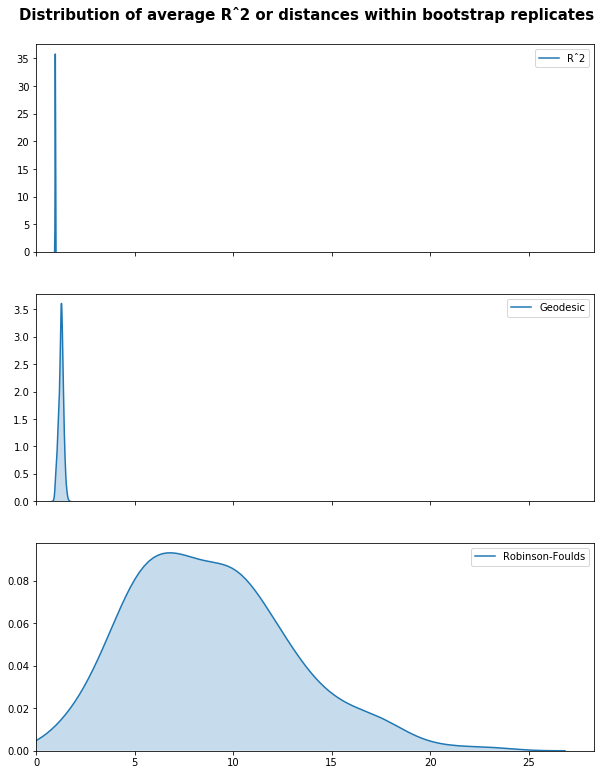

In [67]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 13))

sns.kdeplot(odr_mean, label=f'Rˆ2', shade=True, ax=axs[0])

sns.kdeplot(geo_mean, label=f'Geodesic', shade=True, ax=axs[1])

sns.kdeplot(rf_mean,  label=f'Robinson-Foulds', shade=True, ax=axs[2])

axs[-1].set_xlim(0)
fig.suptitle('Distribution of average Rˆ2 or distances within bootstrap replicates', 
             y=0.92, 
             fontsize=15,
             fontweight='bold'
            );

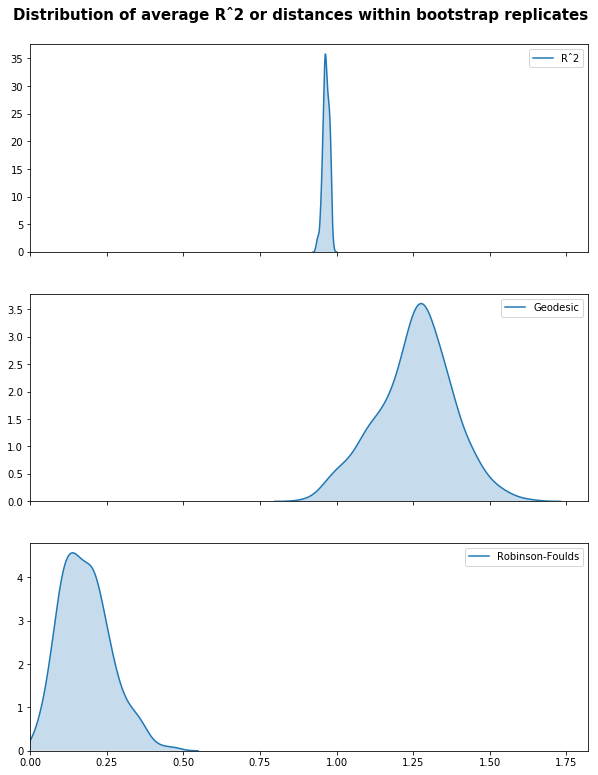

In [75]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 13))

sns.kdeplot(odr_mean, label=f'Rˆ2', shade=True, ax=axs[0])

sns.kdeplot(geo_mean, label=f'Geodesic', shade=True, ax=axs[1])

sns.kdeplot(rf_mean,  label=f'Robinson-Foulds', shade=True, ax=axs[2])

axs[-1].set_xlim(0)
fig.suptitle('Distribution of average Rˆ2 or distances within bootstrap replicates', 
             y=0.92, 
             fontsize=15,
             fontweight='bold'
            );

In [76]:
odr_var_coef = [np.std(position)/np.mean(position)
                for position in all_Rsquareds]

geo_var_coef = [np.std(position)/np.mean(position)
                for position in geodesics]

rf_var_coef  = [np.std(position)/np.mean(position)
                for position in rfs]

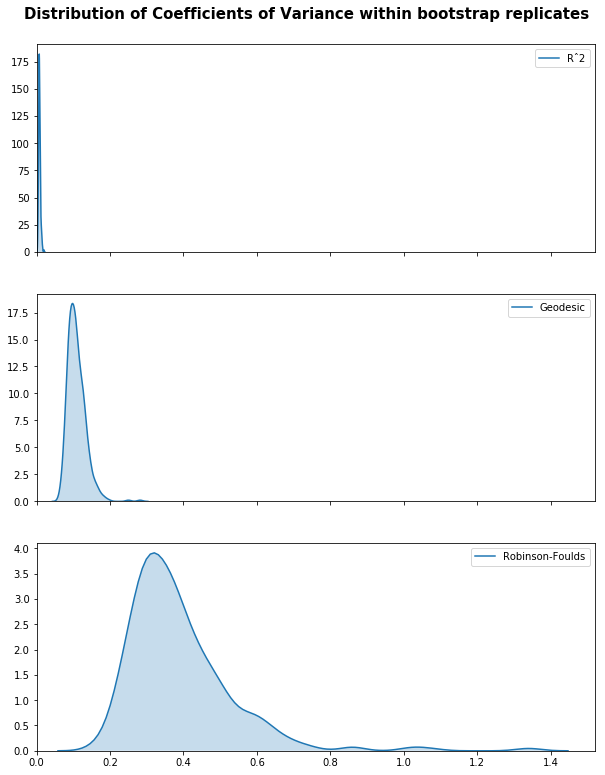

In [77]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 13))

sns.kdeplot(odr_var_coef, label=f'Rˆ2', shade=True, ax=axs[0])

sns.kdeplot(geo_var_coef, label=f'Geodesic', shade=True, ax=axs[1])

sns.kdeplot(rf_var_coef,  label=f'Robinson-Foulds', shade=True, ax=axs[2])

axs[-1].set_xlim(0)
fig.suptitle('Distribution of Coefficients of Variance within bootstrap replicates', 
             y=0.92, 
             fontsize=15,
             fontweight='bold'
            );

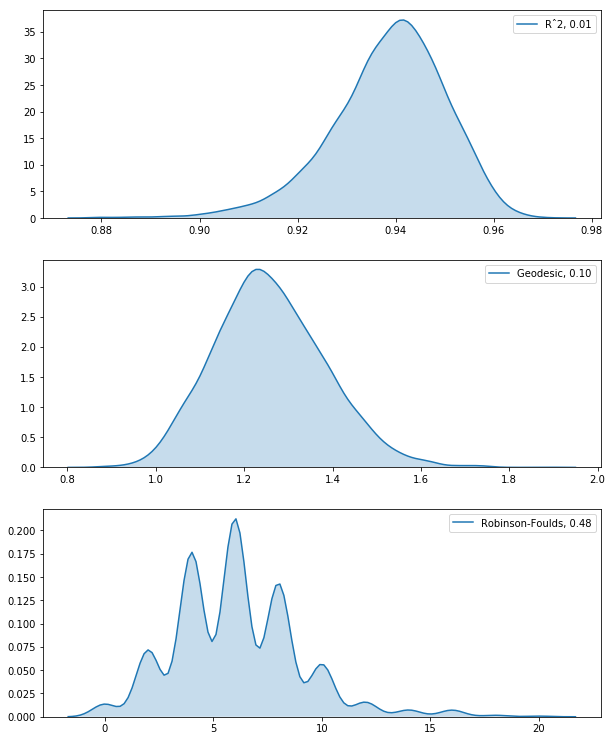

In [42]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 13))

var_coef = np.std(r2s)/np.mean(r2s)
sns.kdeplot(r2s, label=f'Rˆ2, {var_coef:.2f}', shade=True, ax=axs[0])

var_coef = np.std(condensed_geo_distances)/np.mean(condensed_geo_distances)
sns.kdeplot(condensed_geo_distances, label=f'Geodesic, {var_coef:.2f}', shade=True, ax=axs[1])

var_coef = np.std(condensed_rf_distances)/np.mean(condensed_rf_distances)
sns.kdeplot(condensed_rf_distances,  label=f'Robinson-Foulds, {var_coef:.2f}', shade=True, ax=axs[2])